# Decision Tree

Required libraries

In [ ]:
import time
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree, DecisionTreeRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import precision_recall_curve, auc, roc_auc_score, accuracy_score, ConfusionMatrixDisplay, classification_report, confusion_matrix, roc_curve, PrecisionRecallDisplay, RocCurveDisplay, mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from scipy.stats import randint
from collections import Counter

Loading the dataset and required variables

In [ ]:
# Load the dataset
file_path = 'https://raw.githubusercontent.com/Aniket302/Cares_Data/main/CARES_data_imputed.csv'
df = pd.read_csv(file_path)

# Selecting the variables for the model
var = ['Age', 'RCRI score', 'PreopEGFRMDRD', 'Preoptransfusionwithin30days', 'Intraop', 'Postopwithin30days',
      'Transfusionintraandpostop', 'Gender_Female',
       'Anemia category_Moderate', 'Anemia category_Severe',
       'GradeofKidneydisease_G2', 'GradeofKidneydisease_G3a', 'GradeofKidneydisease_G3b',
       'GradeofKidneydisease_G4', 'GradeofKidneydisease_G5',
       'AnaestypeCategory_GA', 'PriorityCategory_Emergency', 'TransfusionIntraandpostopCategory_1 unit',
       'TransfusionIntraandpostopCategory_2 or more units', 'AGEcategory_30-49', 'AGEcategory_50-64', 'AGEcategory_65-74',
       'AGEcategory_75-84', 'AGEcategory_>=85', 'SurgRiskCategory_High', 'SurgRiskCategory_Moderate',
       'RaceCategory_Chinese', 'RaceCategory_Indian', 'RaceCategory_Malay',
       'RDW15.7_>15.7', 'ASAcategorybinned_IV-VI', 'CVARCRICategory_True', 'IHDRCRICategory_True', 'CHFRCRICategory_True',
       'DMinsulinRCRICategory_True', 'CreatinineRCRICategory_True']

In [ ]:
# Creating a copy of the dataframe
data = df.copy()

# List of outcome variables
outcome_vars = ['DaysbetweenDeathandoperation', '@30daymortality', 'Mortality', 'thirtydaymortality', 'ICUAdmgt24h']

## Decision Tree Function

In [ ]:
def decision_tree(target_variable):
    start_time = time.time()

    # Remove rows where the target variable is missing
    data_clean = data.dropna(subset=[target_variable])

    # Define the feature set and the target
    X = data_clean[var]
    y = data_clean[target_variable]

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    if (target_variable != 'DaysbetweenDeathandoperation'):

        print(Counter(y_train))

        # Data Balancing using SMOTE
        smote = SMOTE(random_state=42)
        X_train, y_train = smote.fit_resample(X_train, y_train)

        print(Counter(y_train))

        # Create and fit the decision tree classifier
        decision_tree = DecisionTreeClassifier(random_state=42)
        decision_tree.fit(X_train, y_train)

        # Make predictions
        y_pred = decision_tree.predict(X_test)

        # Predict probabilities for the test set
        y_proba = decision_tree.predict_proba(X_test)[:, 1]

        # Calculate runtime
        runtime = time.time() - start_time
        print(f"Runtime: {runtime:.2f} seconds")

        # Compute ROC curve and AUC
        fpr, tpr, thresholds = roc_curve(y_test, y_proba)
        auc_score = roc_auc_score(y_test, y_proba)

        cm = confusion_matrix(y_test, y_pred, labels=decision_tree.classes_)

        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

        print("\nConfusion Matrix:")
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=decision_tree.classes_)
        disp.plot()

        # plot_roc_curve(dTree, X_test, y_test)
        disp = RocCurveDisplay.from_estimator(decision_tree, X_test, y_test)
        plt.plot()

        # plot_roc_curve(dTree, X_test, y_test,pos_label=0)
        disp = RocCurveDisplay.from_estimator(decision_tree, X_test, y_test,pos_label=0)
        plt.plot()

        # Precision Recall plot
        y_pred = decision_tree.predict_proba(X_test)[:, 1]
        disp = PrecisionRecallDisplay.from_predictions(y_test, y_pred)
        # Change the position of the legend
        plt.legend(loc='upper right')
        plt.show()

        # plot_precision_recall_curve(dTree, X_test, y_test,pos_label=0)
        disp = PrecisionRecallDisplay.from_predictions(y_test, y_pred, pos_label=0)
        # Change the position of the legend
        plt.legend(loc='lower right')
        plt.show()

        # Plotting Feature Importances
        importances = decision_tree.feature_importances_
        indices = np.argsort(importances)[::-1]

        plt.figure(figsize=(10, 9))
        plt.title("Feature Importances")
        plt.barh(range(X_train.shape[1]), importances[indices], align="center")
        plt.yticks(range(X_train.shape[1]), [var[i] for i in indices])
        plt.gca().invert_yaxis()  # Invert y-axis to have the most important features at the top
        plt.xlabel("Importance")
        plt.ylabel("Features")
        plt.show()

    else:
        # Initialize the Decision Tree Regressor
        regressor = DecisionTreeRegressor(random_state=42)

        # Fit the model on the training data
        regressor.fit(X_train, y_train)

        # Make predictions on the test data
        y_pred = regressor.predict(X_test)

        # Evaluate the model
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        print(f"Mean Squared Error: {mse:.2f}")
        print(f"R^2 Score: {r2:.2f}")

        # Plot the true vs predicted values (for one feature for simplicity)
        plt.scatter(y_test, y_pred)
        plt.xlabel('True Values')
        plt.ylabel('Predicted Values')
        plt.title('True vs Predicted Values')
        plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--k')
        plt.show()

## Target Variable = **DaysbetweenDeathandoperation**

Mean Squared Error: 329573.33
R^2 Score: -0.93


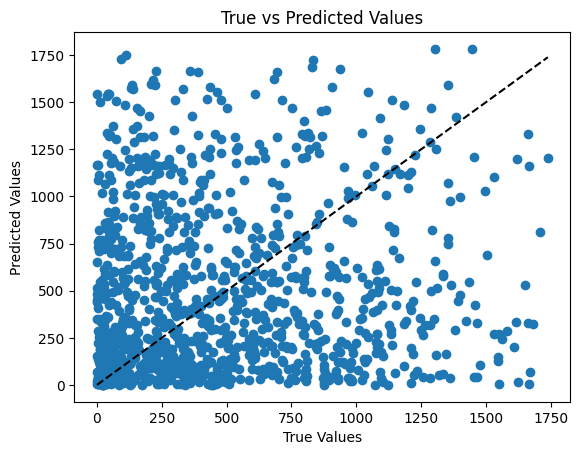

In [ ]:
decision_tree('DaysbetweenDeathandoperation')

## Target Variable = **@30daymortality**

Counter({False: 72181, True: 447})
Counter({False: 72181, True: 72181})
Runtime: 2.29 seconds

Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.99      0.99     18065
        True       0.11      0.17      0.13        92

    accuracy                           0.99     18157
   macro avg       0.55      0.58      0.56     18157
weighted avg       0.99      0.99      0.99     18157


Confusion Matrix:


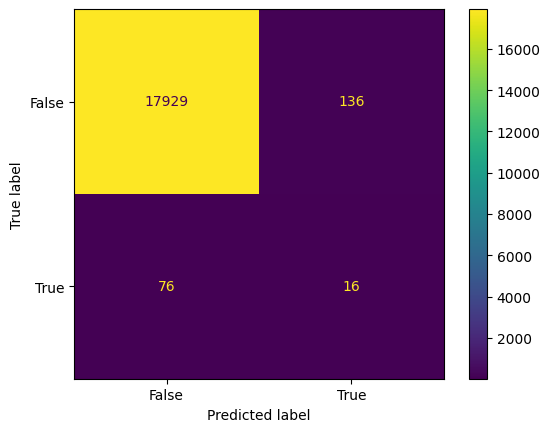

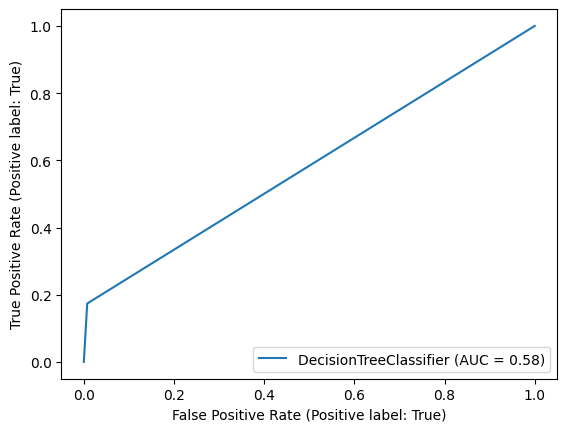

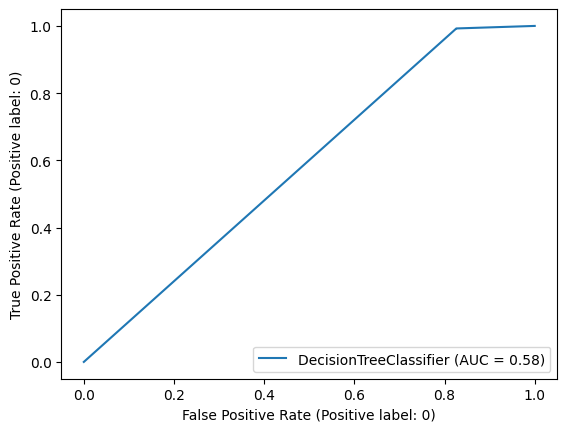

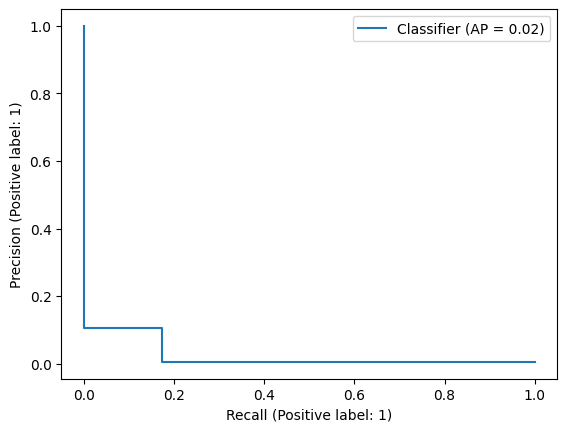

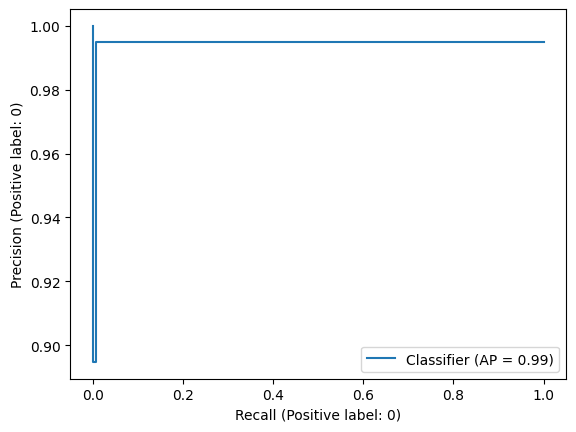

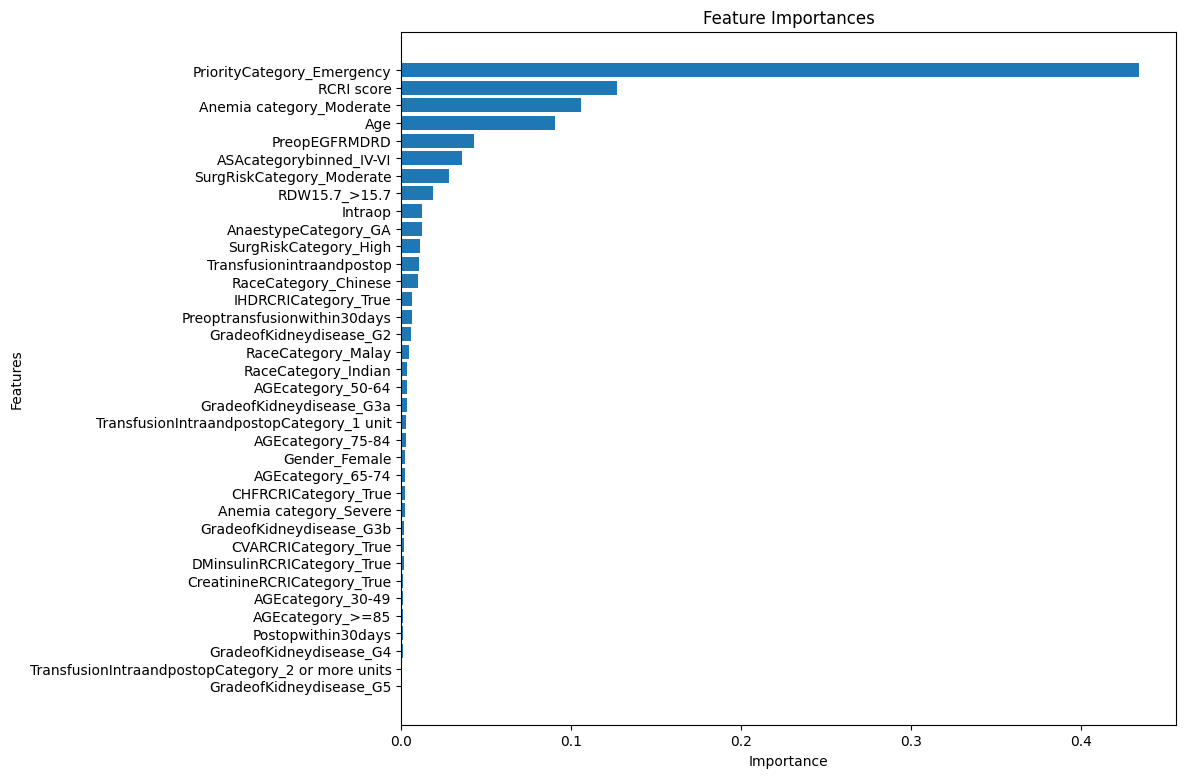

In [ ]:
decision_tree('@30daymortality')

## Target Variable = **Mortality**

Runtime: 1.60 seconds

Classification Report:
              precision    recall  f1-score   support

       False       0.95      0.94      0.95     17050
        True       0.25      0.28      0.26      1107

    accuracy                           0.90     18157
   macro avg       0.60      0.61      0.61     18157
weighted avg       0.91      0.90      0.91     18157


Confusion Matrix:


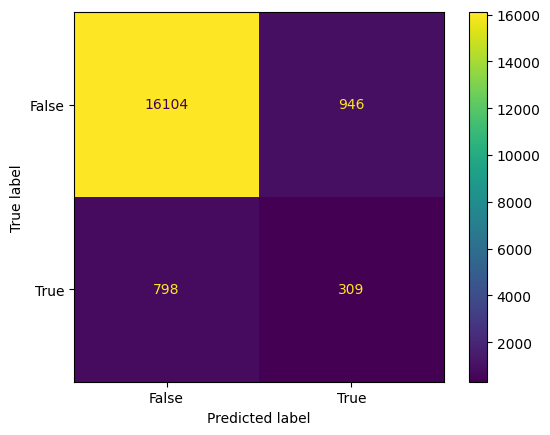

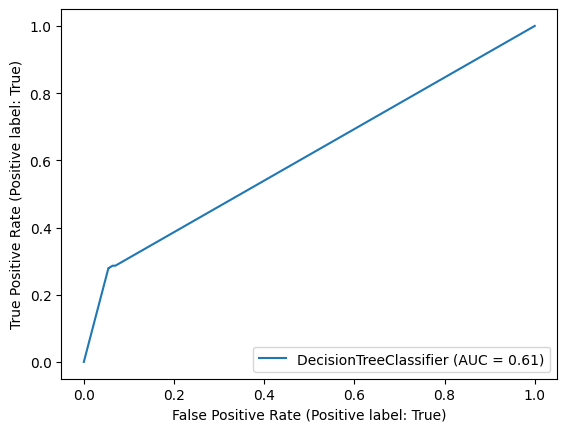

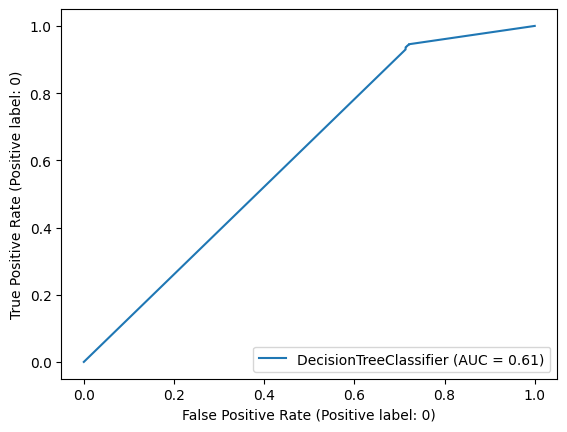

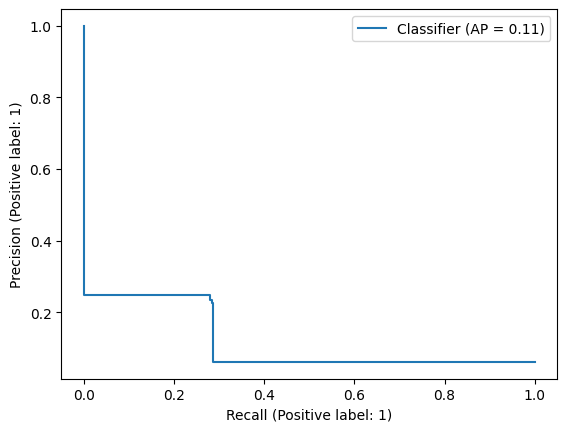

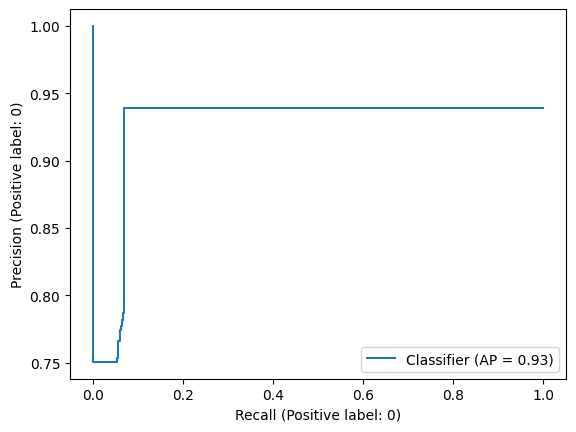

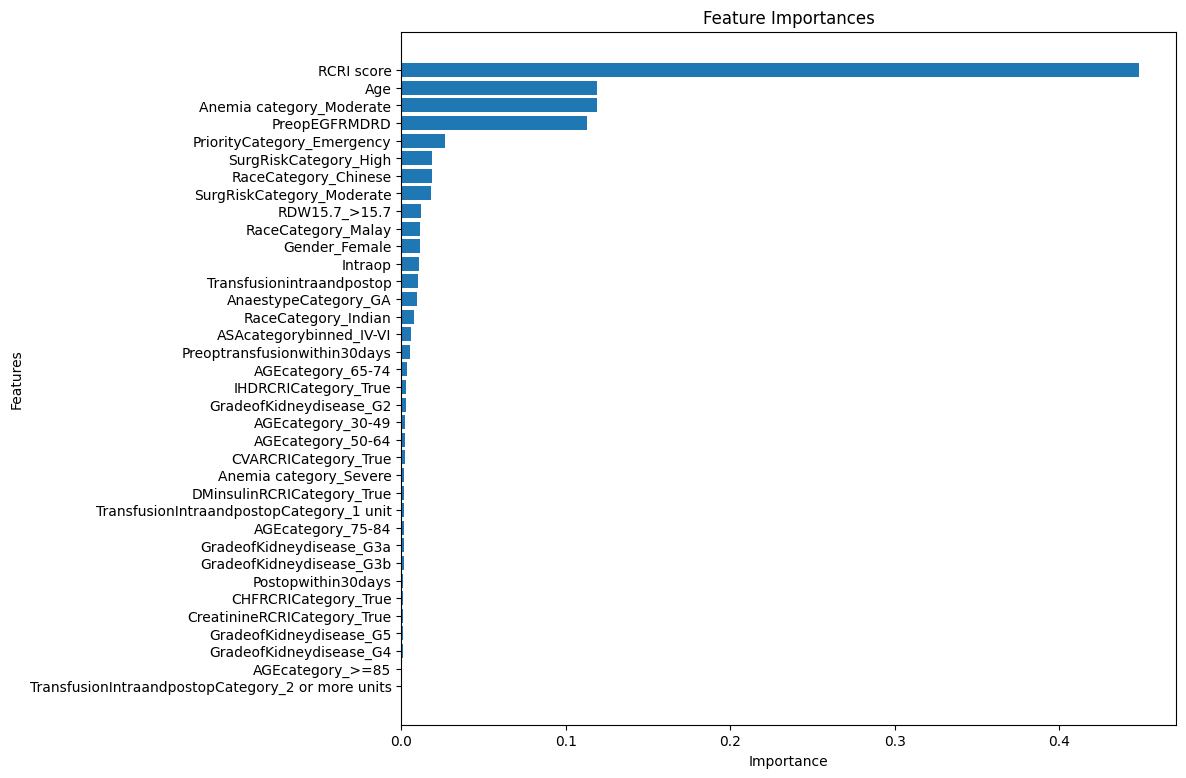

In [ ]:
decision_tree('Mortality')

## Target Variable = **thirtydaymortality**

Runtime: 2.05 seconds

Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.99      0.99     18065
        True       0.11      0.17      0.13        92

    accuracy                           0.99     18157
   macro avg       0.55      0.58      0.56     18157
weighted avg       0.99      0.99      0.99     18157


Confusion Matrix:


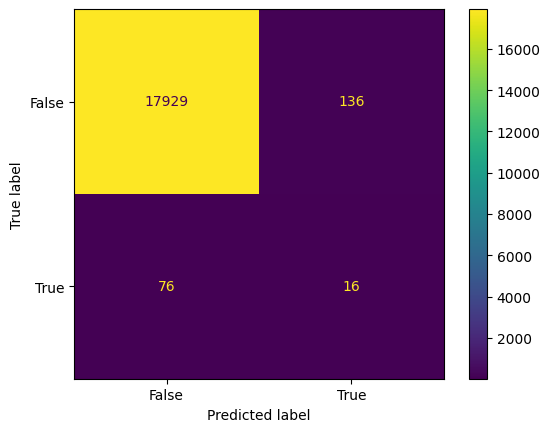

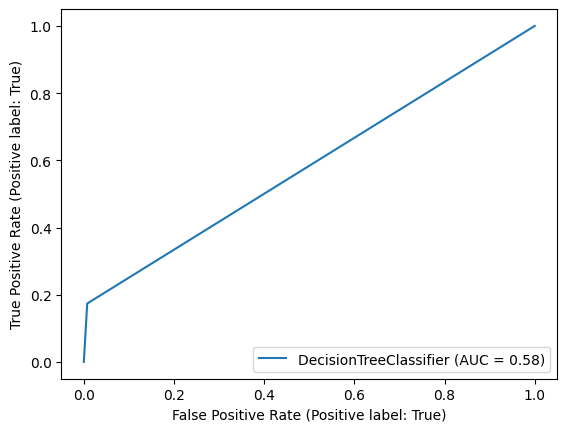

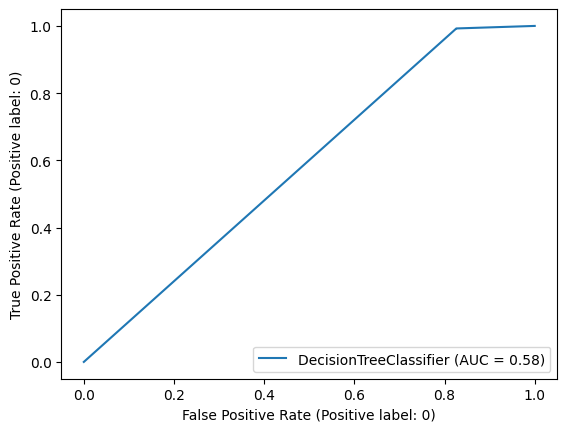

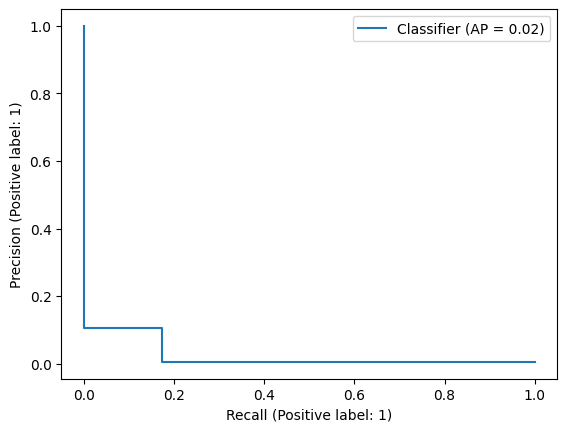

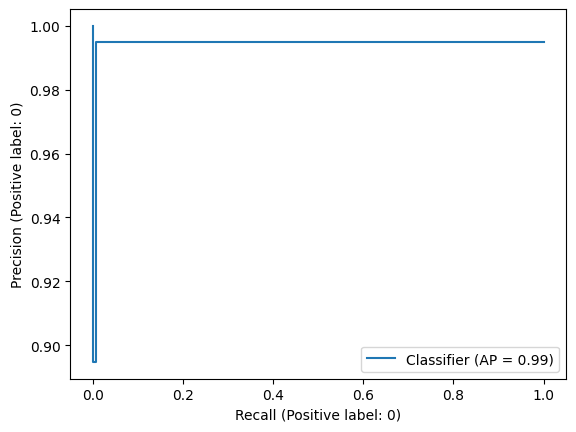

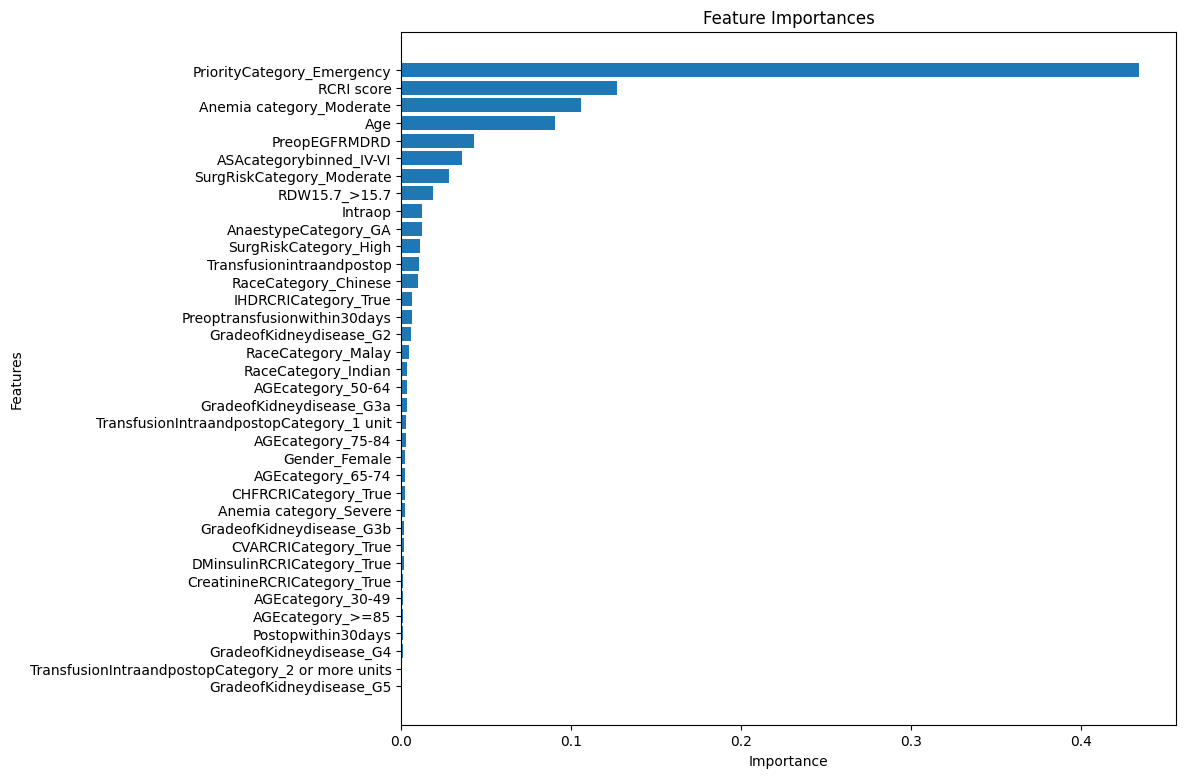

In [ ]:
decision_tree('thirtydaymortality')

## Target Variable = **ICUAdmgt24h**

Runtime: 2.20 seconds

Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.99      0.99     17882
        True       0.20      0.22      0.21       275

    accuracy                           0.98     18157
   macro avg       0.59      0.60      0.60     18157
weighted avg       0.98      0.98      0.98     18157


Confusion Matrix:


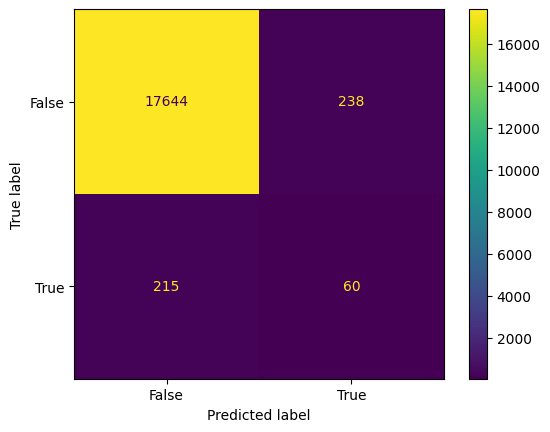

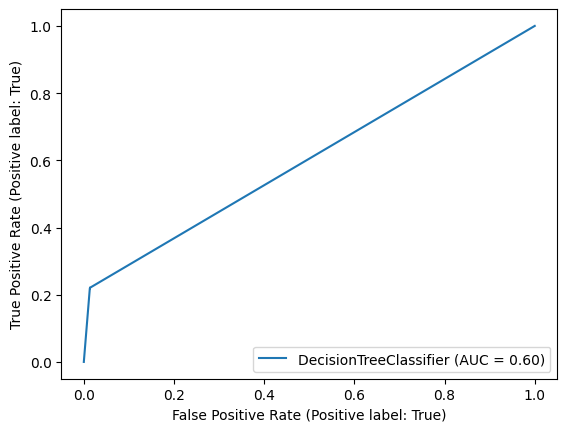

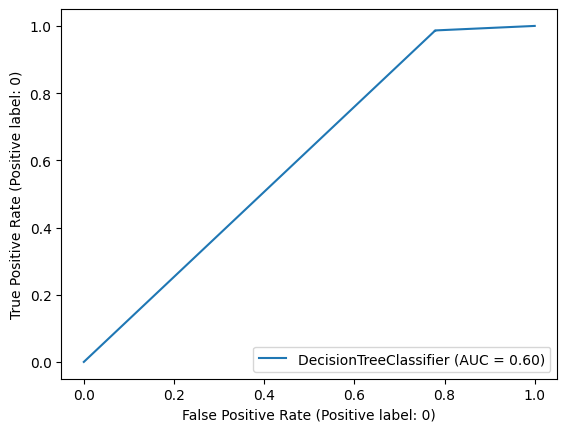

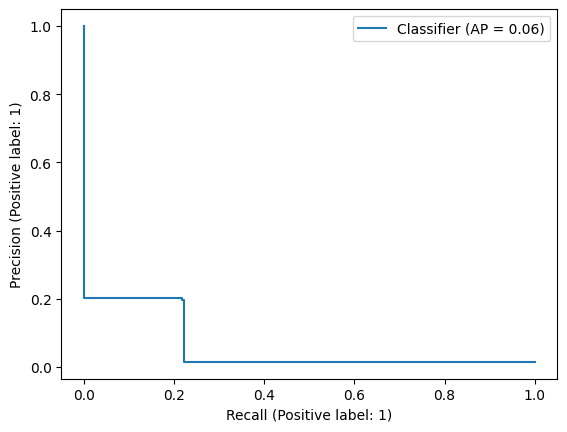

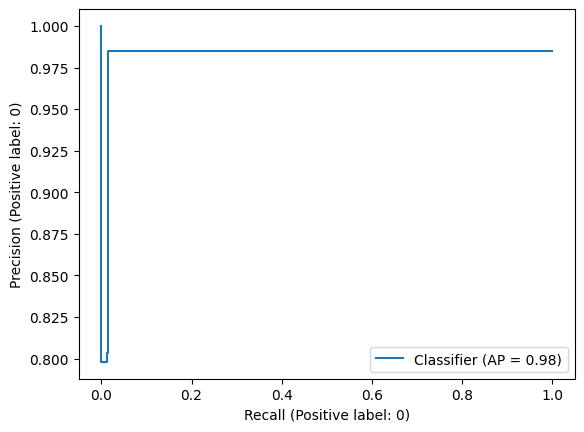

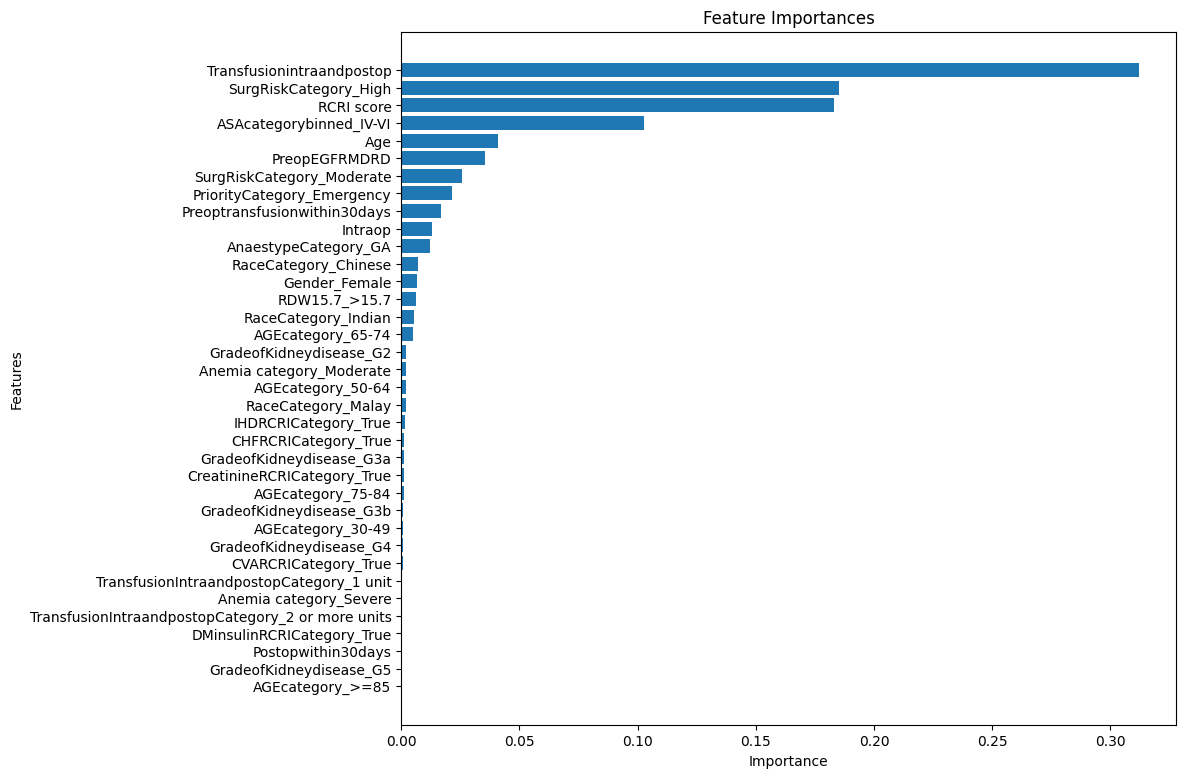

In [ ]:
decision_tree('ICUAdmgt24h')

The overall accuracy for all classification target variables is >0.90. However it is primarily driven by False class. For True class, all (precision, recall, f1) scores are quite low <=0.25

# **Improving Decision Tree with Hyperparameter Tuning**

## For continous variable - Days between death and operation

### 1. Grid Search

In [ ]:
target_variable = 'DaysbetweenDeathandoperation'

# Remove rows where the target variable is missing
data_clean = data.dropna(subset=[target_variable])

# Define the feature set and the target
X = data_clean[var]
y = data_clean[target_variable]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the DecisionTreeRegressor
dt_regressor = DecisionTreeRegressor(random_state=42)

# Define the parameter grid
param_grid = {
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2', None]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=dt_regressor,
                           param_grid=param_grid,
                           cv=5,        # 5-fold cross-validation
                           verbose=2,
                           n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score (R²):", grid_search.best_score_)

# Evaluate on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("Test Set R²:", r2_score(y_test, y_pred))
print("Test Set MSE:", mean_squared_error(y_test, y_pred))

Fitting 5 folds for each of 864 candidates, totalling 4320 fits
Best Parameters: {'criterion': 'poisson', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2}
Best Cross-Validation Score (R²): -0.004712841330191652
Test Set R²: -0.026848574078130794
Test Set MSE: 174991.27255981468


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
1080 fits failed out of a total of 4320.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
684 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ut

### 2. Random Search

In [ ]:
target_variable = 'DaysbetweenDeathandoperation'

# Remove rows where the target variable is missing
data_clean = data.dropna(subset=[target_variable])

# Define the feature set and the target
X = data_clean[var]
y = data_clean[target_variable]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the DecisionTreeRegressor
dt_regressor = DecisionTreeRegressor(random_state=42)

param_dist = {
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': np.arange(2, 11),  # [2, 3, 4, ..., 10]
    'min_samples_leaf': np.arange(1, 5),    # [1, 2, 3, 4]
    'max_features': ['auto', 'sqrt', 'log2', None]
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=dt_regressor,
                                   param_distributions=param_dist,
                                   n_iter=100,  # Number of parameter settings that are sampled
                                   cv=5,        # 5-fold cross-validation
                                   verbose=2,
                                   n_jobs=-1,
                                   random_state=42)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Best parameters and best score
print("Best Parameters:", random_search.best_params_)
print("Best Cross-Validation Score (R²):", random_search.best_score_)

# Evaluate on the test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
print("Test Set R²:", r2_score(y_test, y_pred))
print("Test Set MSE:", mean_squared_error(y_test, y_pred))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters: {'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 10, 'criterion': 'poisson'}
Best Cross-Validation Score (R²): -0.004712841330191652
Test Set R²: -0.026848574078130794
Test Set MSE: 174991.27255981468


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
115 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
115 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/util

## For classification variables

### 1. Grid Search (takes >10 min to run)

In [ ]:
def decision_tree_gs(target_variable):
    # Define the feature set and the target
    X = data[var]
    y = data[target_variable]

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Data Balancing using SMOTE
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)

    # Create and fit the decision tree classifier
    decision_tree = DecisionTreeClassifier(random_state=42)

    # Define the parameter grid
    param_grid = {
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['auto', 'sqrt', 'log2'],
        'splitter': ['best', 'random']
    }

    # Initialize GridSearchCV
    grid_search = GridSearchCV(estimator=decision_tree, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

    # Fit GridSearchCV
    grid_search.fit(X_train, y_train)

    # Best parameters and best score
    print("Best Parameters:", grid_search.best_params_)
    print("Best Cross-Validation Score:", grid_search.best_score_)

    # Evaluate on the test set
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    print("Test Set Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

In [ ]:
decision_tree_gs('@30daymortality')

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
720 fits failed out of a total of 2160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
362 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/uti

Best Parameters: {'criterion': 'gini', 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'splitter': 'best'}
Best Cross-Validation Score: 0.9939388875180025
Test Set Accuracy: 0.9906372198050338
Classification Report:
               precision    recall  f1-score   support

       False       1.00      1.00      1.00     18065
        True       0.08      0.08      0.08        92

    accuracy                           0.99     18157
   macro avg       0.54      0.54      0.54     18157
weighted avg       0.99      0.99      0.99     18157



In [ ]:
decision_tree_gs('Mortality')

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
720 fits failed out of a total of 2160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
357 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/uti

Best Parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'splitter': 'best'}
Best Cross-Validation Score: 0.9409157616671558
Test Set Accuracy: 0.9091810321088285
Classification Report:
               precision    recall  f1-score   support

       False       0.95      0.95      0.95     17050
        True       0.26      0.27      0.27      1107

    accuracy                           0.91     18157
   macro avg       0.61      0.61      0.61     18157
weighted avg       0.91      0.91      0.91     18157



In [ ]:
decision_tree_gs('thirtydaymortality')

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
720 fits failed out of a total of 2160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
359 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/uti

Best Parameters: {'criterion': 'gini', 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'splitter': 'best'}
Best Cross-Validation Score: 0.9939388875180025
Test Set Accuracy: 0.9906372198050338
Classification Report:
               precision    recall  f1-score   support

       False       1.00      1.00      1.00     18065
        True       0.08      0.08      0.08        92

    accuracy                           0.99     18157
   macro avg       0.54      0.54      0.54     18157
weighted avg       0.99      0.99      0.99     18157



In [ ]:
decision_tree_gs('ICUAdmgt24h')

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
720 fits failed out of a total of 2160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
357 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/uti

Best Parameters: {'criterion': 'gini', 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'splitter': 'best'}
Best Cross-Validation Score: 0.988169916888968
Test Set Accuracy: 0.980943988544363
Classification Report:
               precision    recall  f1-score   support

       False       0.99      0.99      0.99     17882
        True       0.30      0.19      0.23       275

    accuracy                           0.98     18157
   macro avg       0.64      0.59      0.61     18157
weighted avg       0.98      0.98      0.98     18157



### 2. Random Search

In [ ]:
def decision_tree_rs(target_variable):
    # Define the feature set and the target
    X = data[var]
    y = data[target_variable]

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Data Balancing using SMOTE
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)

    # Create and fit the decision tree classifier
    decision_tree = DecisionTreeClassifier(random_state=42)

    param_dist = {
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 10, 20, 30, 40, 50],
        'min_samples_split': np.arange(2, 11),  # [2, 3, 4, ..., 10]
        'min_samples_leaf': np.arange(1, 5),    # [1, 2, 3, 4]
        'max_features': ['auto', 'sqrt', 'log2', None],
        'splitter': ['best', 'random']
    }

    # Initialize RandomizedSearchCV
    random_search = RandomizedSearchCV(estimator=decision_tree,
                                    param_distributions=param_dist,
                                    n_iter=100,
                                    cv=5,
                                    verbose=2,
                                    n_jobs=-1,
                                    random_state=42)

    # Fit RandomizedSearchCV
    random_search.fit(X_train, y_train)

    # Best parameters and best score
    print("Best Parameters:", random_search.best_params_)
    print("Best Cross-Validation Score:", random_search.best_score_)

    # Evaluate on the test set
    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_test)
    print("Test Set Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

In [ ]:
decision_tree_rs('@30daymortality')

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
115 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
115 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/util

Best Parameters: {'splitter': 'best', 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None, 'criterion': 'entropy'}
Best Cross-Validation Score: 0.9936687367770286
Test Set Accuracy: 0.9894806410750675
Classification Report:
               precision    recall  f1-score   support

       False       1.00      0.99      0.99     18065
        True       0.10      0.13      0.11        92

    accuracy                           0.99     18157
   macro avg       0.55      0.56      0.55     18157
weighted avg       0.99      0.99      0.99     18157



In [ ]:
decision_tree_rs('Mortality')

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
115 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
115 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/util

Best Parameters: {'splitter': 'best', 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 50, 'criterion': 'entropy'}
Best Cross-Validation Score: 0.9429923686527737
Test Set Accuracy: 0.9094564079969157
Classification Report:
               precision    recall  f1-score   support

       False       0.95      0.95      0.95     17050
        True       0.25      0.24      0.25      1107

    accuracy                           0.91     18157
   macro avg       0.60      0.60      0.60     18157
weighted avg       0.91      0.91      0.91     18157



In [ ]:
decision_tree_rs('thirtydaymortality')

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
115 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
115 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/util

Best Parameters: {'splitter': 'best', 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None, 'criterion': 'entropy'}
Best Cross-Validation Score: 0.9936687367770286
Test Set Accuracy: 0.9894806410750675
Classification Report:
               precision    recall  f1-score   support

       False       1.00      0.99      0.99     18065
        True       0.10      0.13      0.11        92

    accuracy                           0.99     18157
   macro avg       0.55      0.56      0.55     18157
weighted avg       0.99      0.99      0.99     18157



In [ ]:
decision_tree_rs('ICUAdmgt24h')

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
115 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
115 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/util

Best Parameters: {'splitter': 'best', 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': None, 'max_depth': 30, 'criterion': 'gini'}
Best Cross-Validation Score: 0.9891889206691866
Test Set Accuracy: 0.9794018835710745
Classification Report:
               precision    recall  f1-score   support

       False       0.99      0.99      0.99     17882
        True       0.25      0.17      0.20       275

    accuracy                           0.98     18157
   macro avg       0.62      0.58      0.60     18157
weighted avg       0.98      0.98      0.98     18157



# Random Forest

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, average_precision_score, PrecisionRecallDisplay, accuracy_score

In [ ]:
def random_forest(target_variable):
    start_time = time.time()

    # Remove rows where the target variable is missing
    data_clean = data.dropna(subset=[target_variable])

    # Define the feature set and the target
    X = data_clean[var]
    y = data_clean[target_variable]

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    if target_variable != 'DaysbetweenDeathandoperation':
        # Data Balancing using SMOTE
        smote = SMOTE(random_state=42)
        X_train, y_train = smote.fit_resample(X_train, y_train)

        # Initialize the Random Forest classifier
        rf_classifier = RandomForestClassifier(random_state=42)

        # Train the classifier
        rf_classifier.fit(X_train, y_train)

        # Make predictions on the test set
        y_pred = rf_classifier.predict(X_test)
        y_pred_prob = rf_classifier.predict_proba(X_test)[:, 1]

        # Calculate runtime
        runtime = time.time() - start_time
        print(f"Runtime: {runtime:.2f} seconds")

        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Accuracy: {accuracy:.2f}")

        # Display classification report
        print("Classification Report:")
        print(classification_report(y_test, y_pred))

        # Plot Feature Importances
        # Feature importances from the training data
        feature_importances = pd.Series(rf_classifier.feature_importances_, index=X_train.columns).sort_values(ascending=False)

        plt.figure(figsize=(10, 9))
        feature_importances.plot.barh()
        plt.title('Feature Importances')
        plt.xlabel('Features')
        plt.ylabel('Importance')
        plt.gca().invert_yaxis()
        plt.show()
        plt.close()

        # ROC Curve
        plt.figure(figsize=(8, 6))
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
        auc_score = roc_auc_score(y_test, y_pred_prob)
        plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc_score)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc="lower right")
        plt.show()
        plt.close()

        # Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
        auprc = auc(recall, precision)
        plt.figure(figsize=(8, 6))
        plt.plot(recall, precision, label='Precision-Recall curve (AUPRC = %0.2f)' % auprc)
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend(loc="lower left")
        plt.show()
        plt.close()

        # Create the confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.title('Confusion Matrix')
        plt.show()
        plt.close()

    else:
        # Initialize the Random Forest Regressor
        rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

        # Fit the model on the training data
        rf_regressor.fit(X_train, y_train)

        # Make predictions on the test data
        y_pred = rf_regressor.predict(X_test)

        # Evaluate the model
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        print(f"Mean Squared Error: {mse:.2f}")
        print(f"Root Mean Squared Error: {rmse:.2f}")
        print(f"Mean Absolute Error: {mae:.2f}")
        print(f"R^2 Score: {r2:.2f}")

        # Plot the true vs predicted values
        plt.scatter(y_test, y_pred)
        plt.xlabel('True Values')
        plt.ylabel('Predicted Values')
        plt.title('True vs Predicted Values')
        plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--k')
        plt.show()

### Target Variable: **DaysbetweenDeathandoperation**

Mean Squared Error: 165476.71
Root Mean Squared Error: 406.79
Mean Absolute Error: 330.02
R^2 Score: 0.03


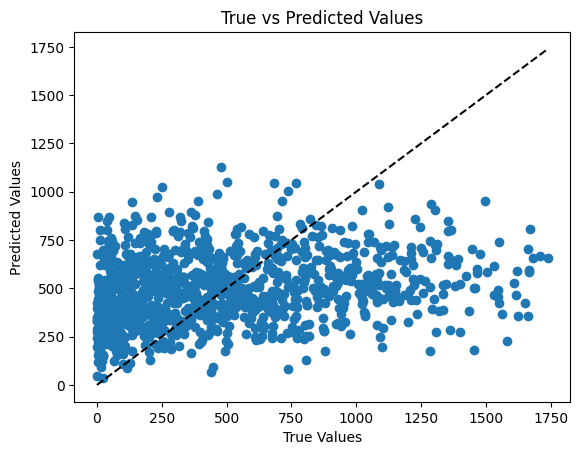

In [ ]:
random_forest('DaysbetweenDeathandoperation')

### Target Variable: **@30daymortality**

Runtime: 22.70 seconds
Accuracy: 0.99
Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     18065
        True       0.25      0.10      0.14        92

    accuracy                           0.99     18157
   macro avg       0.62      0.55      0.57     18157
weighted avg       0.99      0.99      0.99     18157



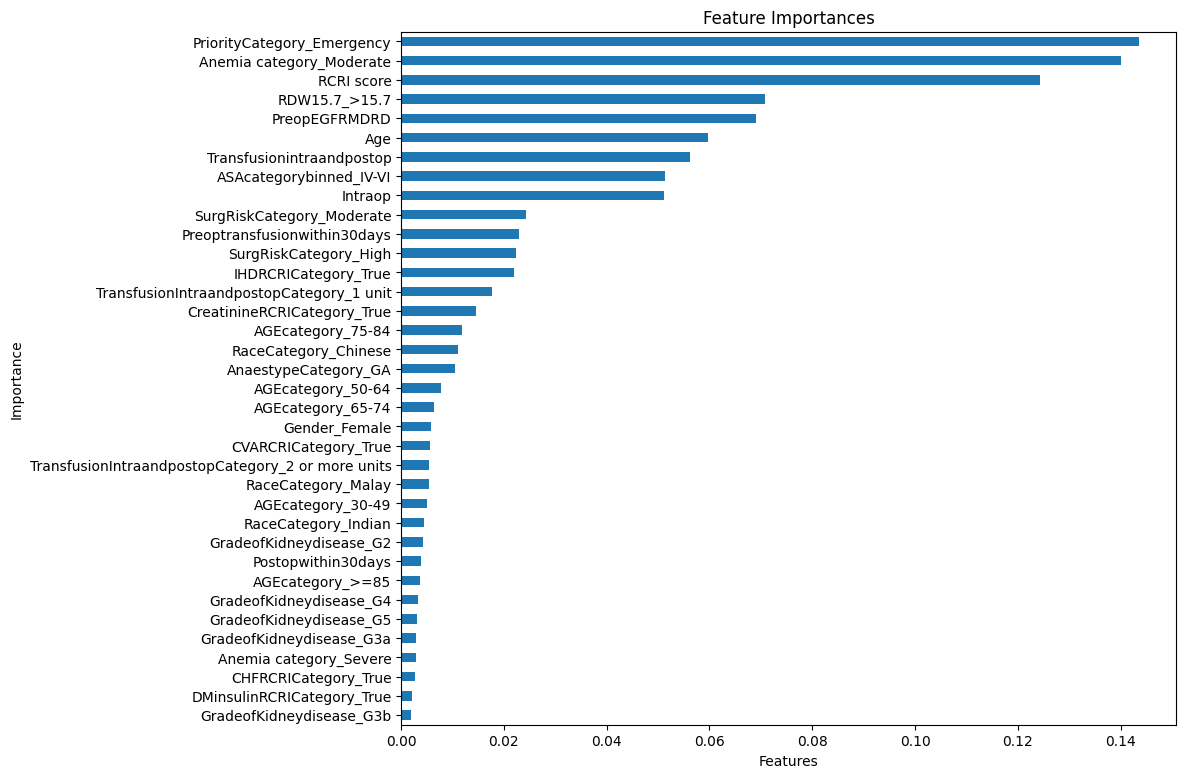

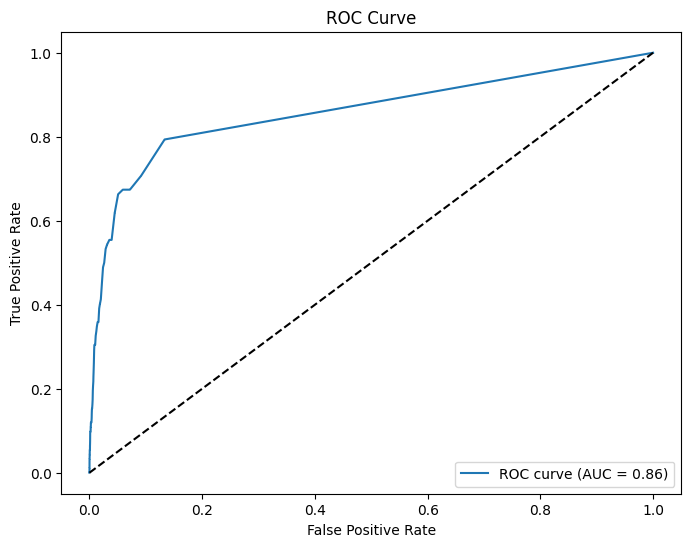

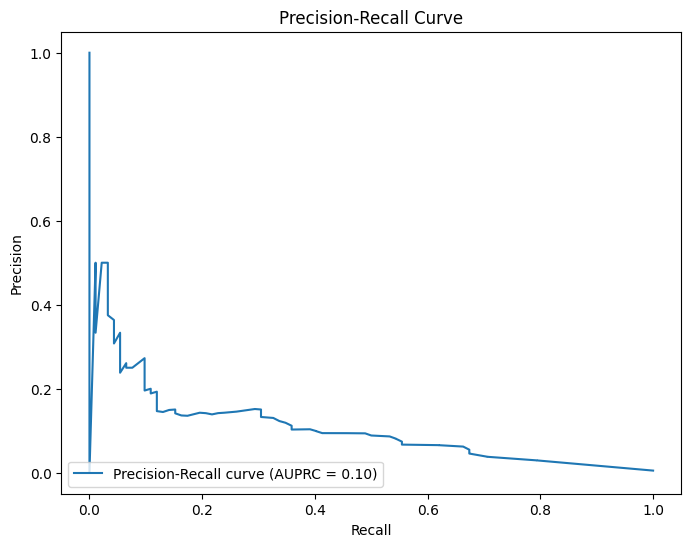

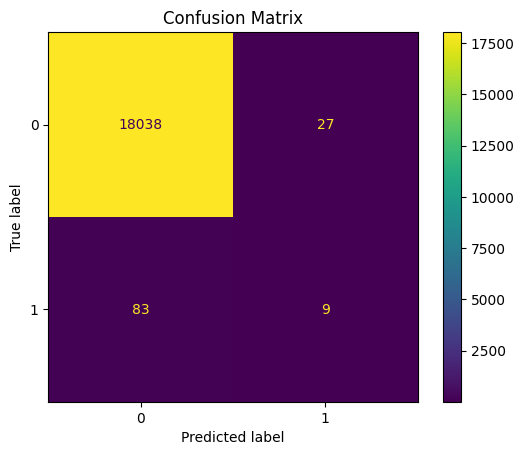

In [ ]:
random_forest('@30daymortality')

### Target Variable: **Mortality**

Runtime: 25.54 seconds
Accuracy: 0.92
Classification Report:
              precision    recall  f1-score   support

       False       0.95      0.96      0.96     17050
        True       0.34      0.28      0.31      1107

    accuracy                           0.92     18157
   macro avg       0.65      0.62      0.63     18157
weighted avg       0.92      0.92      0.92     18157



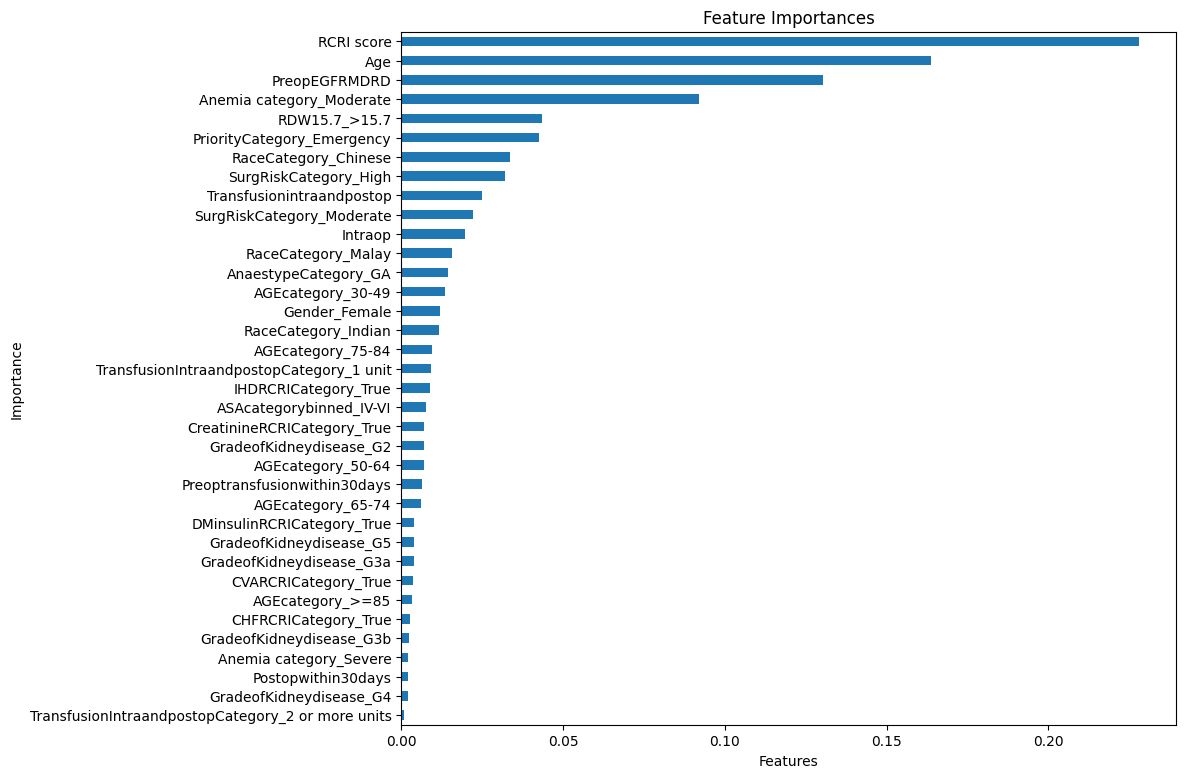

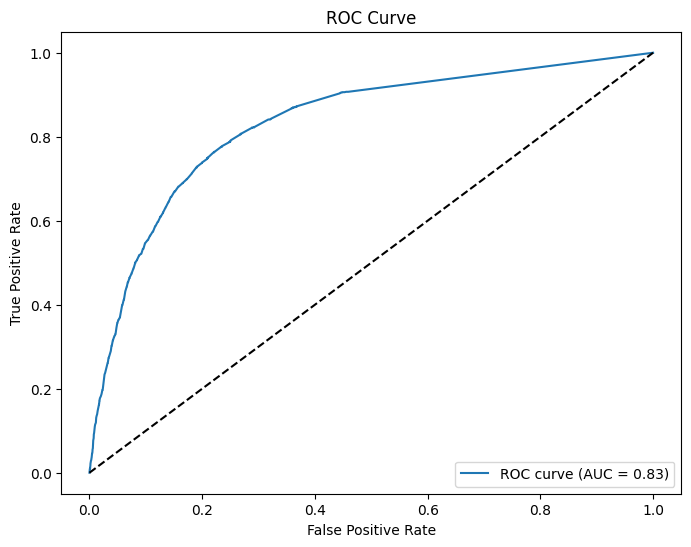

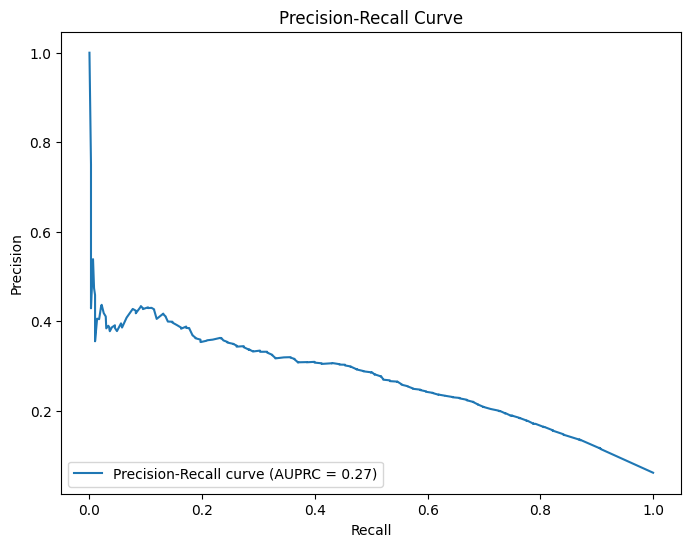

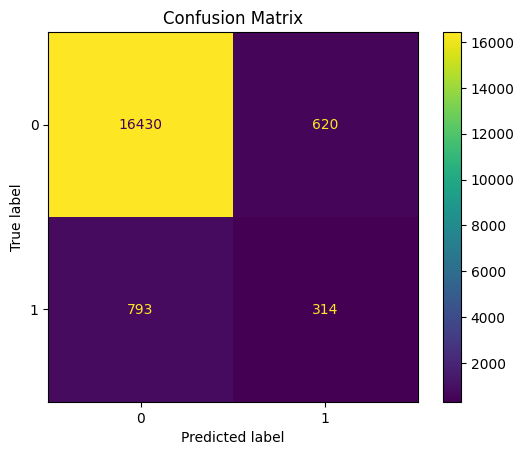

In [ ]:
random_forest('Mortality')

### Target Variable: **thirtydaymortality**

Runtime: 21.55 seconds
Accuracy: 0.99
Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     18065
        True       0.25      0.10      0.14        92

    accuracy                           0.99     18157
   macro avg       0.62      0.55      0.57     18157
weighted avg       0.99      0.99      0.99     18157



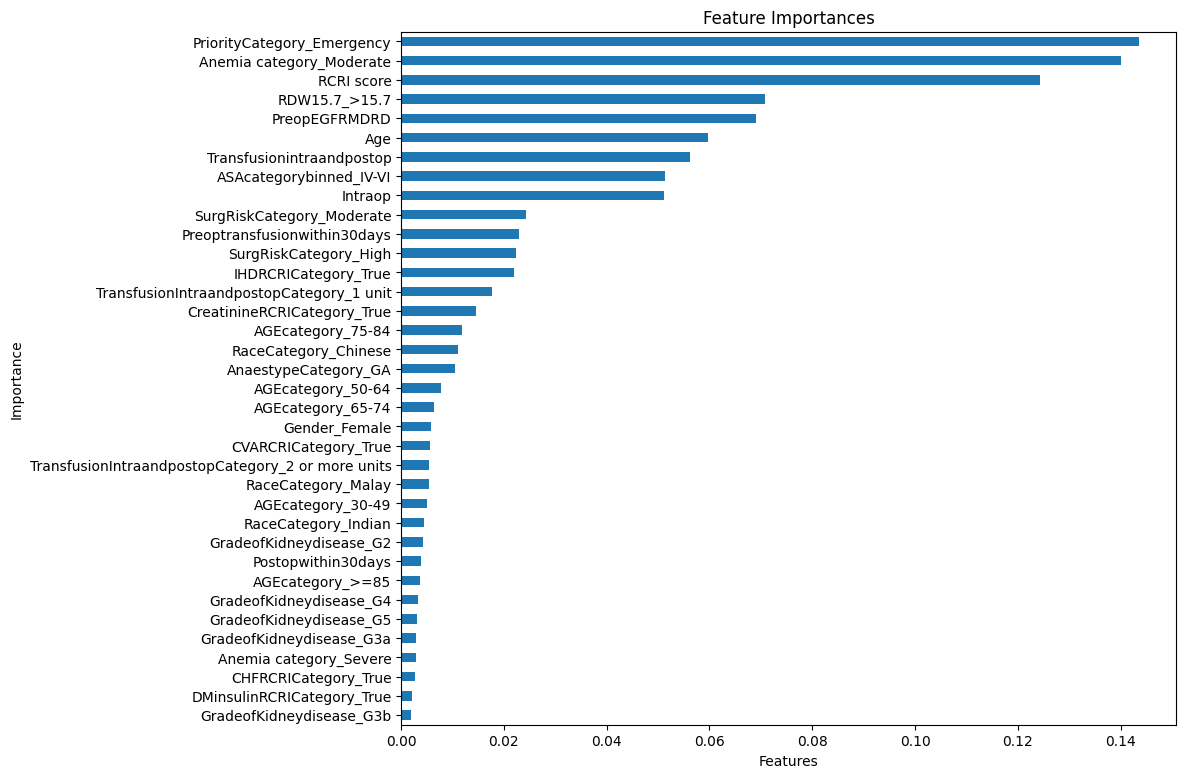

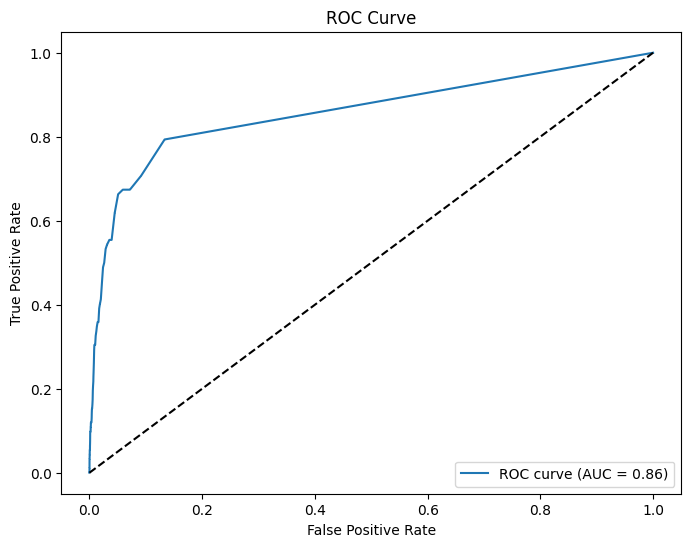

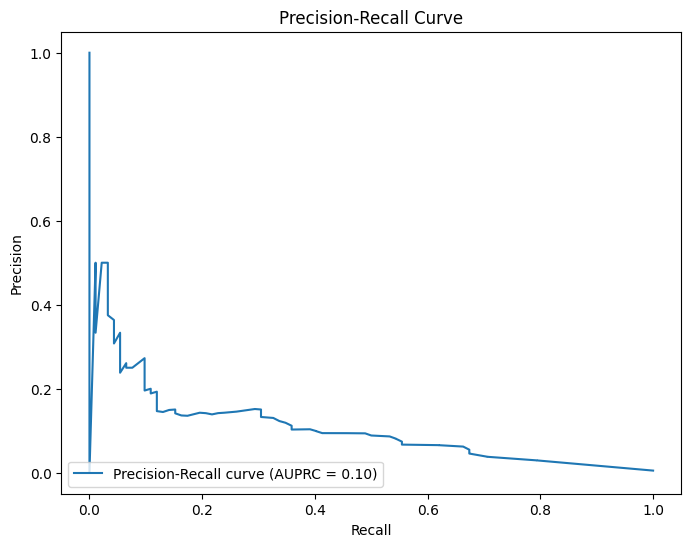

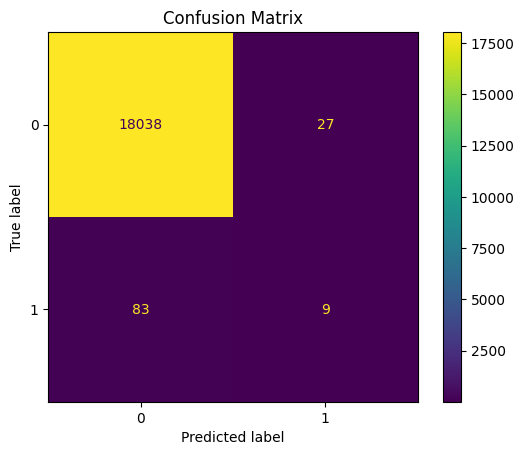

In [ ]:
random_forest('thirtydaymortality')

### Target Variable: **ICUAdmgt24h**

Runtime: 34.36 seconds
Accuracy: 0.98
Classification Report:
              precision    recall  f1-score   support

       False       0.99      1.00      0.99     17882
        True       0.36      0.15      0.21       275

    accuracy                           0.98     18157
   macro avg       0.67      0.57      0.60     18157
weighted avg       0.98      0.98      0.98     18157



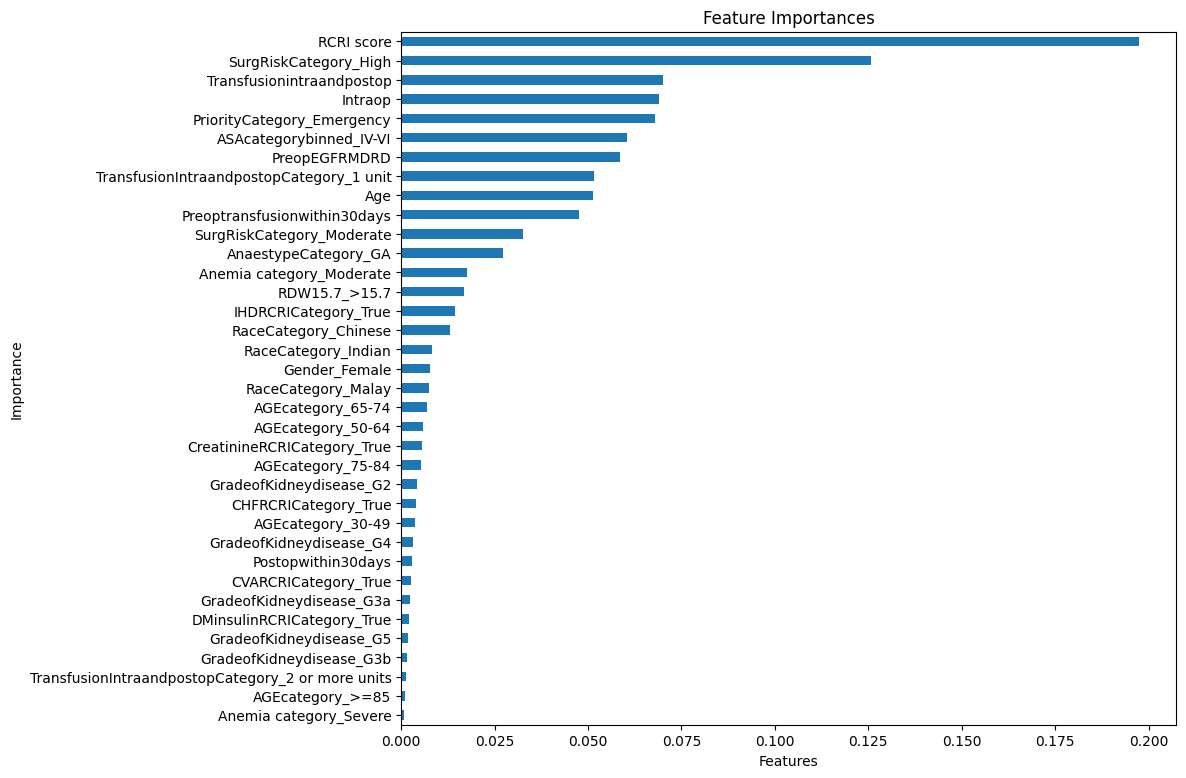

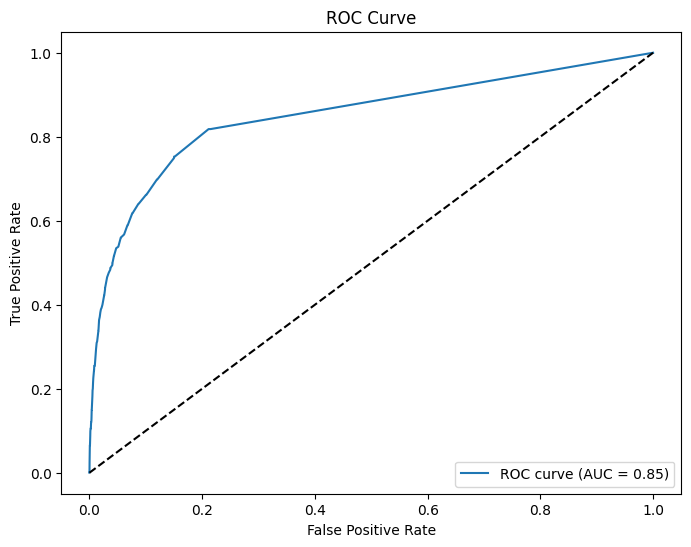

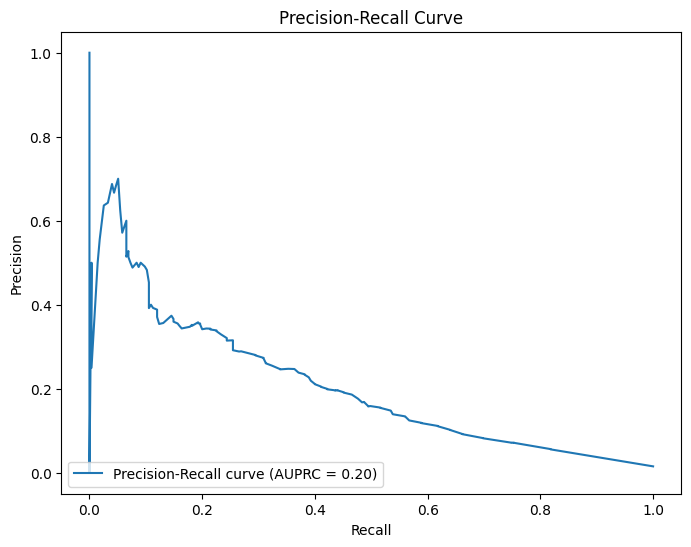

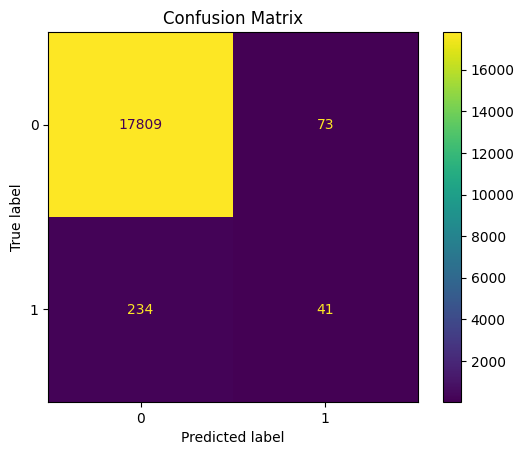

In [ ]:
random_forest('ICUAdmgt24h')

## **Improving Random Forest with Hyperparameter Tuning**

### For DaysbetweenDeathandoperation outcome variable

### 1. Grid Search (takes >10 min to run)

In [ ]:
target_variable = 'DaysbetweenDeathandoperation'

# Remove rows where the target variable is missing
data_clean = data.dropna(subset=[target_variable])

# Define the feature set and the target
X = data_clean[var]
y = data_clean[target_variable]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Initialize the Random Forest Regressor
rf = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit GridSearchCV

grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
203 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py"

Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best Score: 0.09398286200516584


### 2. Random Search

In [ ]:
# Define the parameter distributions
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 11),
    'max_features': ['auto', 'sqrt', 'log2']
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=100, cv=5, n_jobs=-1, verbose=2, random_state=42)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Best parameters and best score
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
160 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
160 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/util

Best Parameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 8, 'n_estimators': 260}
Best Score: 0.09512879616549652


### For remaining outcome variables

### 1. Grid Search (takes >10 min to run)

In [ ]:
def random_forest_gs(target_variable):
    # Define the feature set and the target
    X = data[var]
    y = data[target_variable]

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Data Balancing using SMOTE
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)

    # Initialize the Random Forest classifier
    rf_classifier = RandomForestClassifier(random_state=42)

    # Define the parameter distribution
    param_dist = {
        'n_estimators': [100, 200, 300, 400, 500],           # Number of trees in the forest
        'max_depth': [None, 10, 20, 30, 40, 50],             # Maximum depth of the tree
        'min_samples_split': [2, 5, 10],                     # Minimum number of samples required to split a node
        'min_samples_leaf': [1, 2, 4],                       # Minimum number of samples required at a leaf node
        'max_features': ['auto', 'sqrt', 'log2'],            # Number of features to consider for the best split
        'bootstrap': [True, False],                          # Whether bootstrap samples are used when building trees
        'criterion': ['gini', 'entropy', 'log_loss'],        # Function to measure the quality of a split
    }

    # Initialize RandomizedSearchCV
    random_search = RandomizedSearchCV(estimator=rf_classifier,
                                       param_distributions=param_dist,
                                       n_iter=100,  # Number of parameter settings that are sampled
                                       cv=5,        # 5-fold cross-validation
                                       verbose=2,
                                       n_jobs=-1,
                                       random_state=42)

    # Fit RandomizedSearchCV
    random_search.fit(X_train, y_train)

    # Best parameters and best score
    print("Best Parameters:", random_search.best_params_)
    print("Best Cross-Validation Score:", random_search.best_score_)

    # Evaluate on the test set
    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_test)
    print("Test Set Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

In [ ]:
random_forest_gs('@30daymortality')

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [ ]:
random_forest_gs('Mortality')

In [ ]:
random_forest_gs('thirtydaymortality')

In [ ]:
random_forest_gs('ICUAdmgt24h')

### 2. Random Search

In [ ]:
def random_forest_rs(target_variable):
    # Define the feature set and the target
    X = data[var]
    y = data[target_variable]

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Data Balancing using SMOTE
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)

    # Initialize the Random Forest classifier
    rf_classifier = RandomForestClassifier(random_state=42)

    # Define the parameter grid
    param_grid = {
        'n_estimators': [100, 200, 300],                # Number of trees
        'max_features': ['auto', 'sqrt', 'log2'],       # Number of features to consider at each split
        'max_depth': [None, 10, 20, 30],                # Maximum depth of the trees
        'min_samples_split': [2, 5, 10],                # Minimum number of samples required to split a node
        'min_samples_leaf': [1, 2, 4],                  # Minimum number of samples required at each leaf node
        'bootstrap': [True, False],                     # Whether bootstrap samples are used when building trees
        'criterion': ['gini', 'entropy']                # Function to measure the quality of a split
    }

    # Initialize GridSearchCV
    grid_search = GridSearchCV(estimator=rf_classifier,
                            param_grid=param_grid,
                            cv=5,        # 5-fold cross-validation
                            n_jobs=-1,
                            verbose=2)

    # Fit GridSearchCV
    grid_search.fit(X_train, y_train)

    # Best parameters and best score
    print("Best Parameters:", grid_search.best_params_)
    print("Best Cross-Validation Score:", grid_search.best_score_)

    # Evaluate on the test set
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    print("Test Set Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

In [ ]:
random_forest_rs('@30daymortality')

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits


In [ ]:
random_forest_rs('Mortality')

In [ ]:
random_forest_rs('thirtydaymortality')

In [ ]:
random_forest_rs('ICUAdmgt24h')